### Installation

In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth
    !pip install -U datasets

### Unsloth

In [ ]:
from unsloth import FastVisionModel
import torch

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.7.8: Fast Llama patching. Transformers: 4.53.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.04G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True,  # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True,  # False if not finetuning MLP layers

    r = 8, # Set Rank
    lora_alpha = 8,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # rank stabilized LoRA
    loftq_config = None,
    target_modules = "all-linear",
)

Unsloth: Making `base_model.model.model.vision_tower.vision_model` require gradients


<a name="Data"></a>
### Data Preparation

In [ ]:
# !pip install -U datasets

In [ ]:
from datasets import load_dataset_builder

dataset_id = "AI4Math/MathVista"
builder = load_dataset_builder(dataset_id)
print("Available splits:", builder.info.splits.keys())

README.md: 0.00B [00:00, ?B/s]

Available splits: dict_keys(['testmini', 'test'])


In [ ]:
from datasets import load_dataset, disable_caching

# Disable caching completely
disable_caching()

dataset_id = "AI4Math/MathVista"
dataset = load_dataset(dataset_id, split="testmini")

(…)-00000-of-00001-725687bf7a18d64b.parquet:   0%|          | 0.00/142M [00:00<?, ?B/s]

(…)-00000-of-00002-6b81bd7f7e2065e6.parquet:   0%|          | 0.00/358M [00:00<?, ?B/s]

(…)-00001-of-00002-6a611c71596db30f.parquet:   0%|          | 0.00/386M [00:00<?, ?B/s]

Generating testmini split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5141 [00:00<?, ? examples/s]

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": Q}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": A} ]
},
]
```

In [ ]:
dataset

Dataset({
    features: ['pid', 'question', 'image', 'decoded_image', 'choices', 'unit', 'precision', 'answer', 'question_type', 'answer_type', 'metadata', 'query'],
    num_rows: 1000
})

In [ ]:
dataset[7]

{'pid': '8',
 'question': 'Is the number of tiny gray bicycles that are on the left side of the brown metal sedan greater than the number of things that are to the left of the tiny green bicycle?',
 'image': 'images/8.jpg',
 'decoded_image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=640x480>,
 'choices': ['Yes', 'No'],
 'unit': None,
 'precision': None,
 'answer': 'Yes',
 'question_type': 'multi_choice',
 'answer_type': 'text',
 'metadata': {'category': 'general-vqa',
  'context': 'synthetic scene',
  'grade': 'daily life',
  'img_height': 480,
  'img_width': 640,
  'language': 'english',
  'skills': ['arithmetic reasoning'],
  'source': 'Super-CLEVR',
  'split': 'testmini',
  'task': 'visual question answering'},
 'query': 'Hint: Please answer the question and provide the correct option letter, e.g., A, B, C, D, at the end.\nQuestion: Is the number of tiny gray bicycles that are on the left side of the brown metal sedan greater than the number of things that are to the lef

In [ ]:
from PIL import Image
dataset[7]["decoded_image"].thumbnail((400,400))

In [ ]:
dataset[7]["decoded_image"].size

(640, 480)

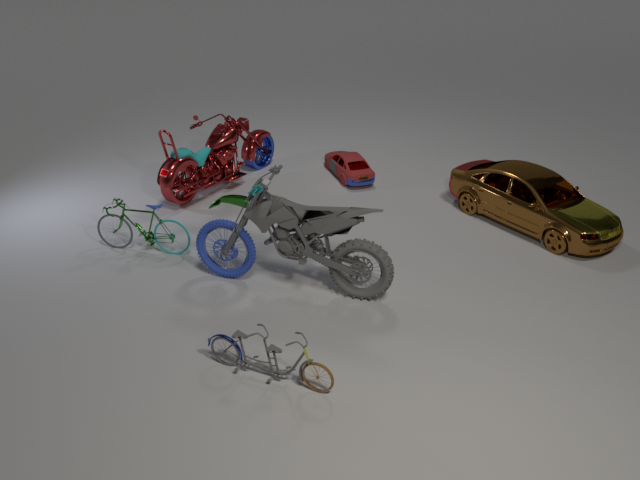

In [ ]:
dataset[7]["decoded_image"]

In [ ]:
dataset[7]["query"]

'Hint: Please answer the question and provide the correct option letter, e.g., A, B, C, D, at the end.\nQuestion: Is the number of tiny gray bicycles that are on the left side of the brown metal sedan greater than the number of things that are to the left of the tiny green bicycle?\nChoices:\n(A) Yes\n(B) No'

In [ ]:
dataset[7]["answer"]

'Yes'

# Format Dataset

In [ ]:
from PIL import Image

def format_data(sample):
    """Format the dataset sample into structured messages."""
    image = sample["decoded_image"].resize((640,480))

    system_message = """You are a Vision Language Model specialized in interpreting visual data from images.
    Your task is to analyze the provided image and respond to queries with detailed answers, explain the thinking process how can you arrive with them.
    Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary."""

    return {
        "messages": [
            {
                "role": "system",
                "content": [{"type": "text", "text": system_message}],
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": sample["query"],
                    },
                    {
                        "type": "image",
                        "image": image,
                    }
                ],
            },
            {
                "role": "assistant",
                "content": [
                    {
                        "type": "text",
                        "text": sample["answer"],
                    }
                ],
            },
        ],
    }

In [ ]:
# Transform the dataset
converted_dataset = [format_data(sample) for sample in dataset]

print(converted_dataset[20])

{'messages': [{'role': 'system', 'content': [{'type': 'text', 'text': 'You are a Vision Language Model specialized in interpreting visual data from images.\n    Your task is to analyze the provided image and respond to queries with detailed answers, explain the thinking process how can you arrive with them.\n    Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.'}]}, {'role': 'user', 'content': [{'type': 'text', 'text': 'Hint: Please answer the question requiring an integer answer and provide the final value, e.g., 1, 2, 3, at the end.\nQuestion: Fill in the blank to describe the model. The model has 4 dots divided into 2 equal groups. There are (_) dots in each group.'}, {'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=640x480 at 0x792EB3B4F6D0>}]}, {'role': 'assistant', 'content': [{'type': 'text', 'text': '2'}]}]}


# Inference baseline model before finetuning

In [ ]:
FastVisionModel.for_inference(model)         # Enable for inference!

image = dataset[7]["decoded_image"]
query = dataset[7]["query"]

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {
                "type": "text",
                "text": query
            },
        ]
    }
]

In [ ]:
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

In [ ]:
if "token_type_ids" in inputs:
    del inputs["token_type_ids"]

In [ ]:
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 64,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

A</s>


<a name="Train"></a>
### Train the model

In [ ]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

training_args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        num_train_epochs = 1,
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "paged_adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    )

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = training_args,
)

In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
6.791 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,000 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 23,527,424 of 7,086,954,496 (0.33% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,3.496300
2,3.379700
3,3.115000
4,2.786500
5,3.117200
6,3.220600
7,3.184200
8,2.704400
9,2.519200
10,2.706800


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

336.1168 seconds used for training.
5.6 minutes used for training.
Peak reserved memory = 6.791 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 46.069 %.
Peak reserved memory for training % of max memory = 0.0 %.


<a name="Inference"></a>
# Inference After Fine Tuning

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[7]["decoded_image"]
query = dataset[7]["query"]

print(query)

Hint: Please answer the question and provide the correct option letter, e.g., A, B, C, D, at the end.
Question: Is the number of tiny gray bicycles that are on the left side of the brown metal sedan greater than the number of things that are to the left of the tiny green bicycle?
Choices:
(A) Yes
(B) No


In [ ]:
messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": query}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

if "token_type_ids" in inputs:
    del inputs["token_type_ids"]

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 64,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

ASSISTANT: 1
OPTION LETTER: A
Correct answer: ASSISTANT: 1
OPTION LETTER: A
Question: Is the number of tiny gray bicycles that are on the left side of the brown metal sedan greater than the number of things


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

['lora_model/processor_config.json']

In [ ]:
from unsloth import FastVisionModel
model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
        device_map="auto",
)
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[7]["decoded_image"]
query = dataset[7]["query"]

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": query}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 64,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

==((====))==  Unsloth 2025.7.8: Fast Llama patching. Transformers: 4.53.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
ASSISTANT: 1
OPTION LETTER: A
Correct answer: ASSISTANT: 1
OPTION LETTER: A
Question: Is the number of tiny gray bicycles that are on the left side of the brown metal sedan greater than the number of things
